# The ARMA framework, part 4: Handling trends and seasonality 

We will introduce ARIMA, SARMA, and SARIMA models as ways of handling trends and seasonality within an ARMA framework, focusing on the application of forecasting GDP (both growth rates and levels, both seasonally adjusted and not). These methods can be compared with the exponential-smoothing approaches from the first two weeks of class.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import math
import numpy as np
from numpy.random import normal

from matplotlib import pyplot as plt

import wrds
import fredapi

from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as LjungBox

import os
from dotenv import load_dotenv
load_dotenv();

# Handling trends: ARIMA processes

Last time we saw how to model the *growth rate* of GDP using the ARMA framework. But suppose we are trying to build forecasts for the *level* of GDP? 

It is not too hard to see how we could convert our forecasts of GDP growth into forecasts of GDP itself, but, this could get complicated as we add more features to the model, or as we try to build prediction intervals or do other analysis beyond building the simple forecast. We would rather have a procedure that can deal directly with the level of GDP.

The problem with doing this in the ARMA framework is that GDP itself is not stationary, due simply to its strong upward trend:

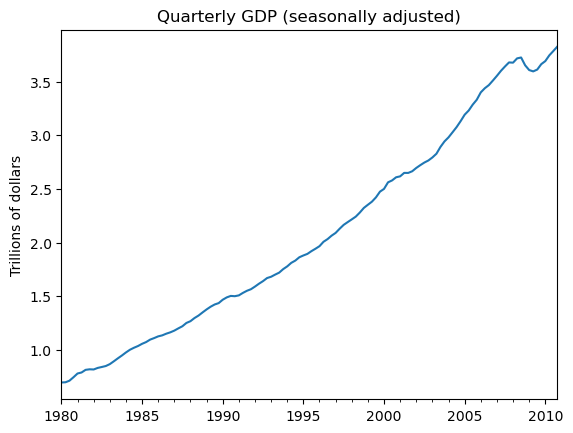

In [2]:
GDP = fredapi.Fred().get_series('GDP'  , observation_start = '1980-01-01', observation_end = '2010-12-31', frequency='q', aggregation_method = 'sum').resample('Q').first()
GDP = GDP / 1000
GDP = GDP / 4
GDP.plot(title="Quarterly GDP (seasonally adjusted)",ylabel="Trillions of dollars");

The series will obviously fail our tests for stationary data (and we showed this explicitly a few weeks ago).

This should remind us of how simple exponential smoothing could not handle trending data. In that situation, we introduced "double" exponential smoothing, where the filter tries to learn about the slope of the process. We would like to do something similar here.

In the ARMA framework, the answer is to introduce a broader category of models called ARIMA$(p,d,q)$ models. An ARIMA$(p,d,q)$ model is simply one that becomes ARMA$(p,q)$ after differencing it $d$ times. 
In all examples that we will see in this course, $d=1$, so an ARIMA$(p,1,q)$ model is one that you can difference to get an ARMA$(p,q)$. 

We decided in our earlier analysis that the growth rate of GDP is stationary and well-described by an AR(1) process, which can also be called an ARMA$(1,0)$ process. So, we would say that log GDP is an ARIMA$(1,1,0)$ process. This can be written formally as:
$$
\Delta y_t = \mu +  \phi \Delta y_{t-1} + u_t
$$
which directly captures what we are saying. There are also other equivalent ways to write the same idea.

This is useful because we can simply give statsmodels the data on GDP, tell it to model that as ARIMA(1,1,0), and it comes pre-loaded with all the necessary calculations to do what we want. It will difference the data and fit an AR$(1)$, exactly as we did last week. Then it will *automatically* reverse the differencing step and give us back forecasts and other analysis for the *level* of GDP instead of its difference. And that avoids the possibility that we would make a mistake along the way.

Let's illustrate:

**Measure GDP in logs**

First, all the above discussion suggests that we will be modeling *log* GDP, so let's calculate that, plot it, and confirm that it too is nonstationary.

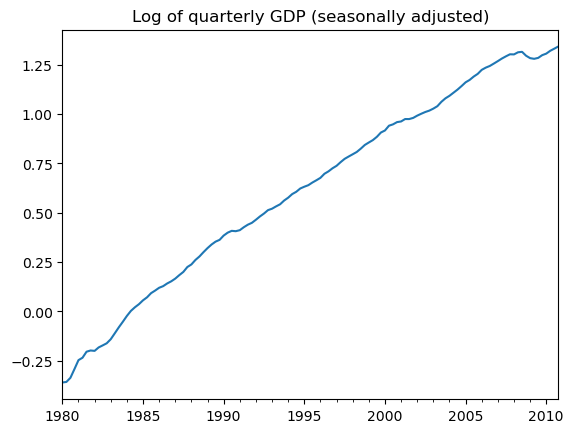

In [3]:
log_GDP = np.log(GDP)
log_GDP.plot(title="Log of quarterly GDP (seasonally adjusted)");

In [4]:
display(adfuller(log_GDP))
display(kpss(log_GDP))

(np.float64(-2.447882818816696),
 np.float64(0.12867519425672735),
 3,
 120,
 {'1%': np.float64(-3.486055829282407),
  '5%': np.float64(-2.8859430324074076),
  '10%': np.float64(-2.5797850694444446)},
 np.float64(-826.5111246699008))

/tmp/ipykernel_1144869/773580839.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  display(kpss(log_GDP))


(np.float64(1.8586002899369887),
 np.float64(0.01),
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

**Estimation**

Now let's estimate the ARIMA$(1,1,0)$ model: From our perspective, the main thing we have to just is just to specify the middle number as 1 in order(1,1,0). Then statsmodels will difference the data and model it as an AR(1), just as we want. If you compare the results below with the AR1 results for GDP growth rate from the previous notebook, you will see that they match exactly.

*Detail*: In order for the above statement to be exactly true, we need specify the option trend='t', to line up with the fact that there was a significant constant term in our AR(1) model for the GDP growth rate. This is necessary because by default, statsmodels assumes you do *not* want to include a constant term when modeling differenced data. If you try to run the model without this option, you will get different numbers, and more importantly the the Ljung-Box test will strongly reject. This reflects the fact GDP growth is indeed positive on average, not zero. We will generally include the option trend='t' in all our ARIMA examples.


(We can safely ignore the warnings about MLE convergence.)

In [5]:
AR1_results = ARIMA(log_GDP.diff().dropna(),order=(1,0,0)).fit()

print( AR1_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  123
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 432.518
Date:                Thu, 01 Jan 2026   AIC                           -859.037
Time:                        14:25:52   BIC                           -850.600
Sample:                    06-30-1980   HQIC                          -855.610
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.001     10.102      0.000       0.011       0.016
ar.L1          0.5234      0.052     10.054      0.000       0.421       0.625
sigma2      5.146e-05   4.51e-06     11.413      0.0

In [6]:
ARIMA110_results = ARIMA(log_GDP,order=(1,1,0)).fit()

print( ARIMA110_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 419.759
Date:                Thu, 01 Jan 2026   AIC                           -835.517
Time:                        14:25:52   BIC                           -829.893
Sample:                    03-31-1980   HQIC                          -833.233
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8739      0.036     24.299      0.000       0.803       0.944
sigma2       6.28e-05    6.2e-06     10.123      0.000    5.06e-05     7.5e-05
Ljung-Box (L1) (Q):                  10.90   Jarque-

/home/william/miniforge3/envs/FIN657/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
ARIMA110_results = ARIMA(log_GDP,order=(0,1,1),trend='t').fit()

print( ARIMA110_results.summary() )

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 426.347
Date:                Thu, 01 Jan 2026   AIC                           -846.695
Time:                        14:25:52   BIC                           -838.258
Sample:                    03-31-1980   HQIC                          -843.268
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0138      0.001     14.549      0.000       0.012       0.016
ma.L1          0.3975      0.057      6.919      0.000       0.285       0.510
sigma2      5.702e-05   5.46e-06     10.438      0.0

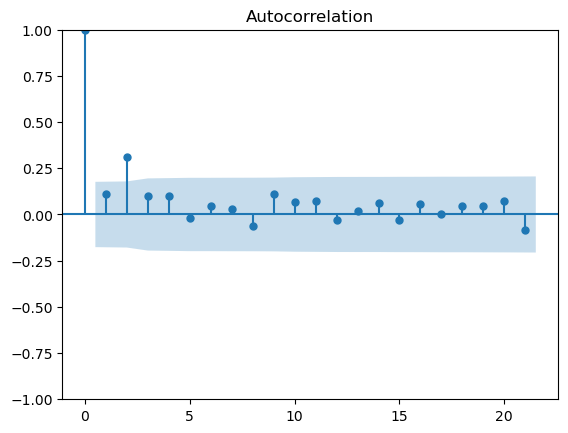

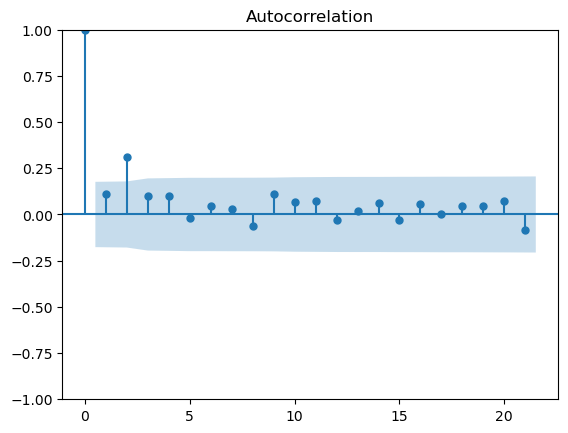

In [8]:
plot_acf( ARIMA110_results.resid[1:] )

**Model selection**

If we didn't already think that ARIMA$(1,1,0)$ was the best model, we could go through our usual model-selection steps: 

- The Ljung-Box test above already fails to reject. 
- If we plot the ACF and PACF of the residuals, we will see no clear patterns. 
    - (If you try this, note that you should drop the first residual. For ARIMA models, the first residual is not really meaningful and will come out much larger than all the other values. This messes up the ACF and PACF plots, and makes it look like there is no pattern in the residuals even if there really is.) 
- The AIC and BIC are not any lower for any other model we could try.

So we would select ARIMA(1,1,0) to model log GDP. 
This is a very standard finding, and of course it's expected since we selected an AR1 to model the *growth rate* of GDP.

**Forecasting**

Now let's build forecasts of GDP for the quarters after the data ends. The methods for this are just like those that we used in the prior notebook. Behind the scenes, statsmodels is just building the same forecasts as before for GDP growth rate, and then converting them back into forecasts for log GDP in levels.

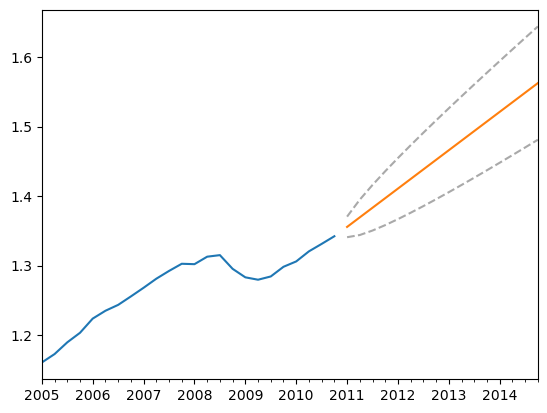

In [9]:
forecasts_frame = ARIMA110_results.get_forecast(16).summary_frame()

log_GDP['2005':].plot();
forecasts_frame['mean'].plot();
forecasts_frame['mean_ci_upper'].plot(style='--',color="darkgray");
forecasts_frame['mean_ci_lower'].plot(style='--',color="darkgray");

# Handling seasonality: SARIMA processes

Now suppose you want to work directly with non-seasonally-adjusted GDP data. This will obviously exhibit seasonality, another form of nonstationary behavior. Let's take a look.

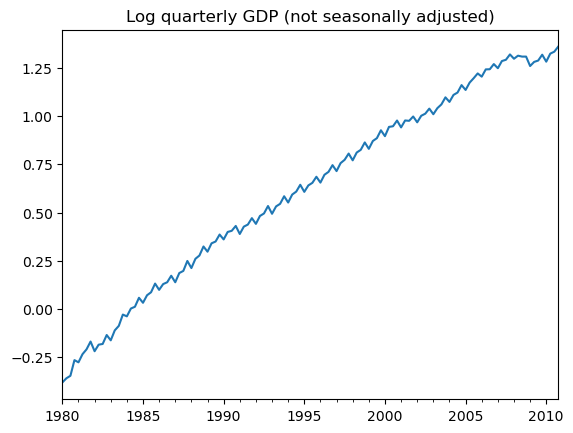

In [10]:
GDPNSA = fredapi.Fred().get_series('NA000334Q'  , observation_start = '1980-01-01', observation_end = '2010-12-31', frequency='q').resample('Q').first()
GDPNSA = GDPNSA / 1e6
log_GDPNSA = np.log(GDPNSA)
log_GDPNSA.plot(title="Log quarterly GDP (not seasonally adjusted)");

In fact, this series clearly has both a trend *and* seasonality. 

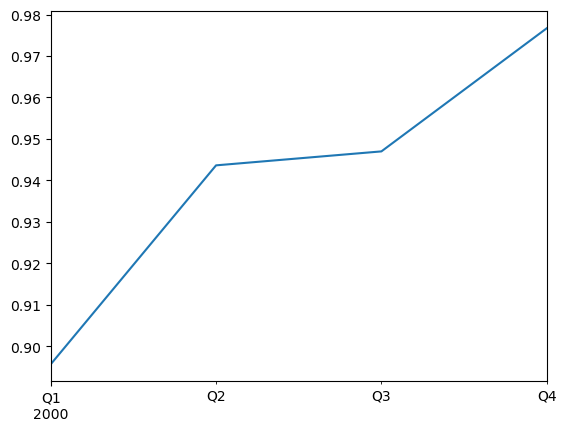

In [11]:
log_GDPNSA['2000'].plot();

To isolate just the seasonality aspect first, let's start by modeling the *growth rate* of GDPNSA, which will exhibit seasonality but not trends.

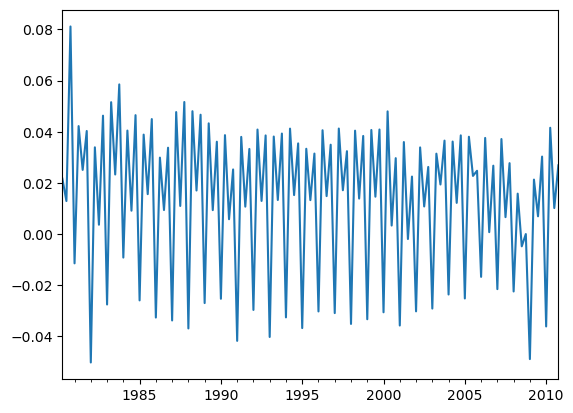

In [12]:
GDPNSA_growth = log_GDPNSA.diff().dropna()
GDPNSA_growth.plot();

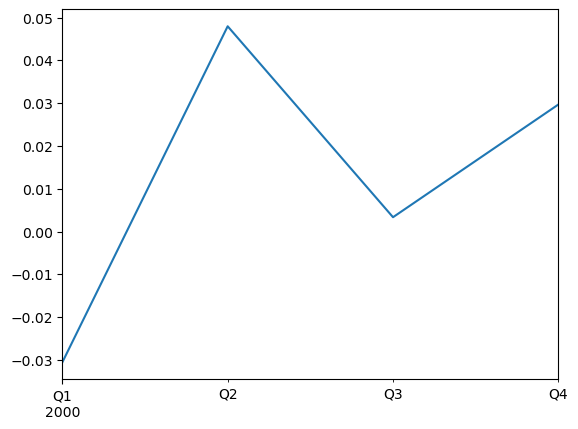

In [13]:
GDPNSA_growth['2000'].plot();

To get some intuition of what we need to do, let's look at the ACF and PACF: We see spikes at each multiple of 4, and weaker spikes at each multiple of 2. These clearly suggest important (quarterly) seasonality. This type effect cannot be modeled with our usual AR or MA processes. 

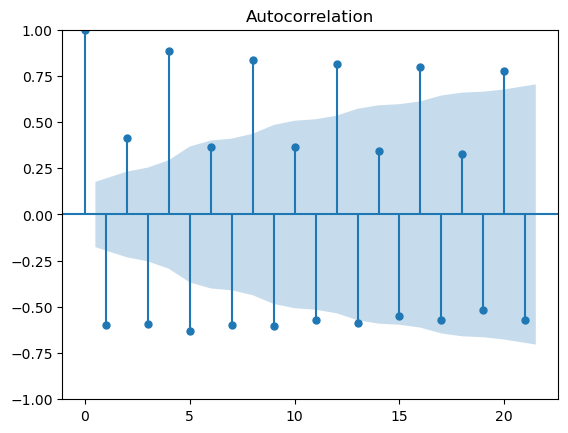

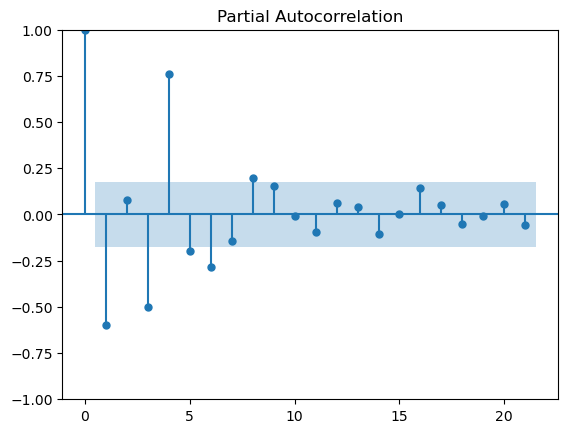

In [14]:
plot_acf(GDPNSA_growth);
plot_pacf(GDPNSA_growth);

The series also fails unit-root and Ljung-Box tests. The reason clearly is not a trend, but rather the predictable seasonality effects within each year.

In [15]:
adfuller(GDPNSA_growth)

(np.float64(-1.8300512886296976),
 np.float64(0.36564739599747903),
 11,
 111,
 {'1%': np.float64(-3.490683082754047),
  '5%': np.float64(-2.8879516565798817),
  '10%': np.float64(-2.5808574442009578)},
 np.float64(-743.610060727743))

In [16]:
kpss(GDPNSA_growth)

(np.float64(0.4597564740225818),
 np.float64(0.051398071541990616),
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [17]:
LjungBox(GDPNSA_growth,lags=1)

,lb_stat,lb_pvalue
1,45.433283,1.579277e-11


### Seasonality, no trend: SARMA model

The SARMA framework (Seasonal ARMA) consists of models that have the usual AR and MA terms, and *also* a second set of "seasonal" AR and MA terms, that operate like normal ones but only over a seasonal lag.

For example, we will find in this example that the growth rate of GDPNSA can be modeled with our usual AR(1) term, plus a seasonal AR(1) term, where each season is 4 dates long (since this is quarterly data).
The formal model for this is as follows:
$$
y_t = \mu + \phi y_{t-1} + \Phi y_{t-4} + u_t
$$

If you aren't familiar with the Greek alphabet, $\phi$ and $\Phi$ are lowercase and uppercase "phi". 
The convention with seasonal ARMA models that all the "seasonal" stuff gets labeled with capital letters.

This turns out to be an elegant way to capture complex patterns of seasonality in the basic ARMA framework,
although it can be confusing to try to think through it at first glance. For example, suppose we are building a forecast of second-quarter GDP for this year:

- The model will put some weight $\phi$ on first-quarter GDP from this year, since any unusual patterns last quarter will probably persist into this quarter.
- But it will also put some weight $\Phi$ on second-quarter GDP from *last* year, since unusual patterns from that quarter might have reflected seasonality that should directly affect second-quarter GDP this quarter, with no effect on the in-between dates.
- How big should $\phi$ and $\Phi$ be? As always, the computer will try to estimate these numbers to fit the past data as closely as possible.

To estimate this model in statsmodels, we just add the option seasonal_order$(1,0,0,4)$. See next section for a full discussion of what this means, but you can already guess that the first number is the number of AR terms, and the last number is the length of each seasonal cycle (in this case it is 4 because we have quarterly data).

In [18]:
GDPNSA_growth_results = ARIMA(GDPNSA_growth,order=(1,0,0),seasonal_order=(1,0,0,4)).fit()

print(GDPNSA_growth_results.summary() )

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  123
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood                 385.709
Date:                         Thu, 01 Jan 2026   AIC                           -763.419
Time:                                 14:25:54   BIC                           -752.170
Sample:                             06-30-1980   HQIC                          -758.849
                                  - 12-31-2010                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0156      0.034      0.460      0.645      -0.051       0.082
ar.L1          0.4089      0.065      6.314      0.000     

We can see that the L-B test now fails to reject. Let's look again at the ACF, PACF, and unit root tests. Things are not perfect, but there is no clear evidence of anything left that we need to do with this series.

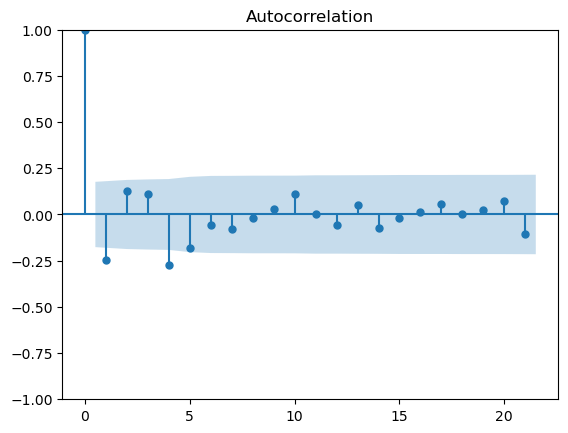

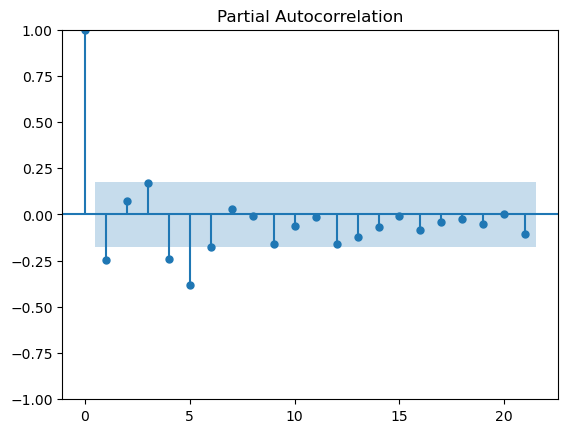

In [19]:
plot_acf( GDPNSA_growth_results.resid );
plot_pacf( GDPNSA_growth_results.resid );

In [20]:
adfuller(GDPNSA_growth_results.resid)

(np.float64(-5.095428509957463),
 np.float64(1.4318776935829065e-05),
 12,
 110,
 {'1%': np.float64(-3.4912451337340342),
  '5%': np.float64(-2.8881954545454547),
  '10%': np.float64(-2.5809876033057852)},
 np.float64(-748.7510073953007))

In [21]:
kpss(GDPNSA_growth_results.resid)

/tmp/ipykernel_1144869/3211164888.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(GDPNSA_growth_results.resid)


(np.float64(0.012603015485705298),
 np.float64(0.1),
 0,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Finally, build forecasts of non-seasonally-adjusted GDP growth for the quarters after the data ends. Again, the tools look just like the ones we have seen before. Now we can see that seasonality is reflected in the forecasts.

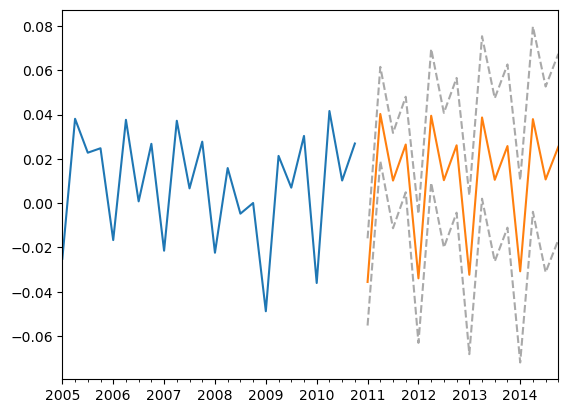

In [22]:
forecasts_frame = GDPNSA_growth_results.get_forecast(16).summary_frame()

GDPNSA_growth['2005':].plot();
forecasts_frame['mean'].plot();
forecasts_frame['mean_ci_upper'].plot(style='--',color="darkgray");
forecasts_frame['mean_ci_lower'].plot(style='--',color="darkgray");

### Seasonality *and* trend: SARIMA model

Finally, suppose you are trying to model non-seasonally-adjusted GDP itself, not its growth rate. We just combine the ARIMA and SARMA approaches to get SARIMA, the most general type of model. 

This category of model is written as SARIMA$(p,d,q)\times(P,D,Q)_s$.

- $P$ is the number of seasonal AR terms.
- $D$ is the number of ``seasonal differencing'' steps that we want to do.
Seasonal differencing is exactly like regular differencing, but is done on a year-over-year basis.
- $Q$ is the number of seasonal MA terms.
- $s$ is the number of dates per seasonal cycle.

So our model from the prior section, for non-seasonally-adjusted GDP growth, is SARIMA$(1,0,0)\times(1,0,0)_4$. And an appropriate model for non-seasonally-adjusted GDP *level* would just replace the first zero with a 1, yielding SARIMA$(1,1,0)\times(1,0,0)_4$. 

This model can be written as
$$
\Delta y_t = \mu + \phi \Delta y_{t-1} + \Phi \Delta y_{t-4} + u_t
$$
As you might expect, the way to estimate this model is to difference the data, and then estimate it exactly like the SARMA model from the prior section. We can let statsmodels do this for us by just giving it the right SARIMA specification, and then (just like ARIMA) it will take care of reversing the differencing and giving us forecasts, etc., in terms of the original level of the data.

Let's try it out:

In [23]:
GDPNSA_results = ARIMA(GDPNSA,order=(1,1,0),seasonal_order=(1,0,0,4),trend='t').fit()
print(GDPNSA_results.summary() )

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                  124
Model:             ARIMA(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 284.758
Date:                         Thu, 01 Jan 2026   AIC                           -561.516
Time:                                 14:25:54   BIC                           -550.267
Sample:                             03-31-1980   HQIC                          -556.947
                                  - 12-31-2010                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0272      0.106      0.257      0.797      -0.180       0.235
ar.L1          0.4008      0.052      7.763      0.000     

The fitted values now do a good job of tracking both the overall trend and the seasonal fluctuations:

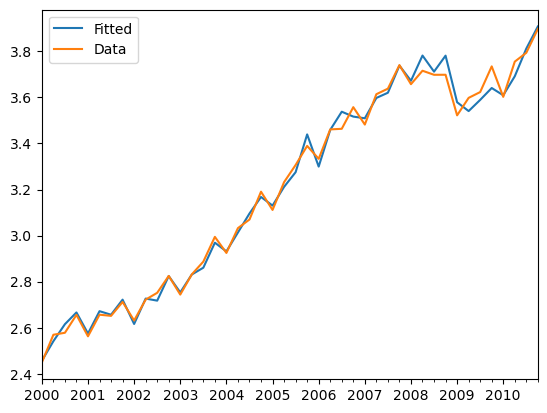

In [24]:
GDPNSA_results.fittedvalues['2000':].plot(legend=True,label="Fitted");
GDPNSA['2000':].plot(legend=True,label="Data");

And we can generate forecasts that now incorporate that seasonality. These are comparable to the results we got with the Holt-Winters algorithm in the first part of the class, since they both capture trend, seasonality, and a residual. 

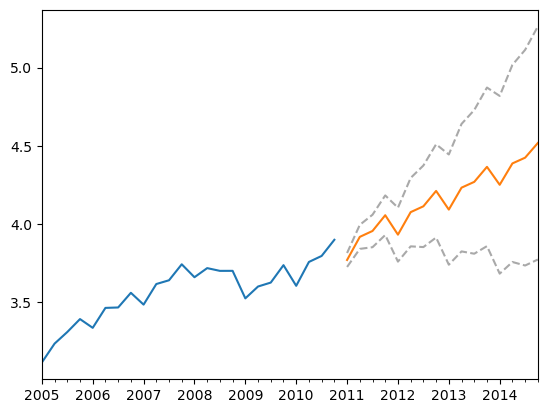

In [25]:
forecasts_frame = GDPNSA_results.get_forecast(16).summary_frame()

GDPNSA['2005':].plot();
forecasts_frame['mean'].plot();
forecasts_frame['mean_ci_upper'].plot(style='--',color="darkgray");
forecasts_frame['mean_ci_lower'].plot(style='--',color="darkgray");

In general, SARIMA and Holt-Winters typically generate predictions that are quite similar, especially over short horizons. The nice thing about SARIMA is that, being based on an ARMA framework, there is clear statistical theory behind everything we are doing, and guidance for how to proceed with other analysis, such as modeling covariates, building prediction intervals, predicting values other than the average, etc.